In [1]:
# !pip install pyLDAvis

In [2]:
# !pip install pymorphy2

In [3]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

import re
import pymorphy2

import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis
import pyLDAvis.lda_model
# import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from tqdm import tqdm_notebook

import warnings

warnings.filterwarnings('ignore')

RAND = 10

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smoik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smoik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Тематическое моделирование
## Импорт данных

In [4]:
# df = pd.read_csv('reviews.csv')
import os

path_to_dir = os.path.abspath('Для AI')
all_file = os.listdir(path_to_dir)
data_dir = {
    'text': [],
    'tema': []
}
for name_file in all_file:
    file_path = os.path.abspath(os.path.join('Для AI', name_file))
    with open(file_path, 'r', encoding='utf-8') as file:
        info = file.read()
        data_dir['text'].append(info)
        data_dir['tema'].append(name_file.replace('.txt', '').replace('_', ' '))
        

In [5]:
data = pd.DataFrame(data_dir)


In [6]:
data

,text,tema
0,Процесс включения синхронного генератора на па...,Автоматизация включения генераторов на паралле...
1,"В тех случаях, когда не требуется гальваническ...",Автотрансформаторные ВУ
2,Выпрямители на диодах и тиристорах обладают из...,Активные выпрямители
3,\nВ системах электроснабжения ЛА имеют место к...,Анализ динамики процессов регулирования напряж...
4,Анализ процессов регулирования напряжения гене...,Анализ динамики процессов регулирования напряж...
...,...,...
112,Принцип действия серебряно-цинковых аккумулято...,Устройство принцип действия и основные характе...
113,"Химический источник тока (ХИТ) -- устройство, ...",Химические источники тока
114,В цифровых регуляторах напряжения (ЦРН) исполн...,Цифровые регуляторы напряжения
115,Среди электромеханических приводов наиболее эф...,Электромеханический привод


**pymorphy2** - морфологический анализатор для русского языка, написанный на языке Python и использующий словари из OpenCorpora. Выполняет лемматизацию и анализ слов, способен осуществлять склонение по заданным грамматическим характеристикам слов.

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
# morph.parse('облаков')[0].normal_form

In [9]:
stopwords.words("russian")[:4]

['и', 'в', 'во', 'не']

In [10]:
def preprocess_text(data, stopwords=stopwords.words("russian")):
    """Очистка текста и удаление стоп-слов"""

    text = re.sub('ё', 'е', data.lower())
    # добавляем пробелы между знаками препинания
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # убираем лишние символы, оставляем буквы, пробелы и зн.пр.
    text = re.sub(r"[^а-яА-Я\s]+", "", text)
    # удаляем пробелы в начале и в конце предложения
    text = text.strip()
    # удаление стоп-слов
    text = [w for w in text.split() if w not in stopwords]
    # удаляем слова короче 3х символов
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)


def lemmatization_text(data, morph=morph):
    """Приведение слов к нормальной форме"""
    
    result = ' '.join([morph.parse(x)[0].normal_form for x in data.split()])
    result = ' '.join(
        [x for x in result.split()])
    return result


def get_result(data, morph=morph, stopwords=stopwords.words("russian")):
    """
    Объединение очистки текста, приведения слов 
    к нормальной форме и токенизации
    """

    if data is not np.NaN:
        result = preprocess_text(data=data)
        result = lemmatization_text(result)
#         result = result.replace('больший', 'большой')
        return result
    return ''

## Очистка текста

In [11]:
X_train, X_test = train_test_split(data.text,
                                   test_size=0.1,
                                   random_state=100)

In [12]:
def transform_data(data: pd.Series) -> list:
    transform_lst = [get_result(data=i) for i in data]
    transform_lst = [x for x in transform_lst if x not in [None, '']]
    return transform_lst


# обработка положительных отзывов
train_lst = transform_data(X_train)
# test_lst = transform_data(X_test)
test_lst = transform_data(X_train)

In [13]:
train_lst[0]

'вертолёт отбор мощность привод генератор правило осуществляться вал главное редуктор несущий винт частота вращение который стабилизироваться высокий точность связь это синхронный генератор приводиться вращение непосредственно редуктор двигатель применение привод постоянный скорость учитывать данный обстоятельство вертолёт применять преимущественно первичный система электроснабжение переменный ток первичный система электроснабжение постоянный ток вертолёт применять запуск двигатель осуществляться электростартер структурный схема типовой система электроснабжение вертолёт привести рис структурный схема система электроснабжение вертолёт первичный система электроснабжение содержать независимый канал генерирование электроэнергия переменный ток каждый который включать свой состав бесконтактный синхронный генератор регулятор напряжение блок защита управление бзу блок трансформатор ток бтт связь генератор вращаться синхронно один вал редуктор система электроснабжение предусмотреть параллельный

In [14]:
# Подсчитаем кол-во слов в предложениях (составление терм-документной матрицы)
vector_ben = CountVectorizer(
    analyzer='word',
    # min_df - частота встречаемого термина < 10
    min_df=10,
    # биграммы, триграммы
    ngram_range=(2, 3),
    stop_words=stopwords.words("russian"))
train_vec_ben = vector_ben.fit_transform(train_lst)

In [15]:
len(train_lst)

104

In [16]:
train_lst

['вертолёт отбор мощность привод генератор правило осуществляться вал главное редуктор несущий винт частота вращение который стабилизироваться высокий точность связь это синхронный генератор приводиться вращение непосредственно редуктор двигатель применение привод постоянный скорость учитывать данный обстоятельство вертолёт применять преимущественно первичный система электроснабжение переменный ток первичный система электроснабжение постоянный ток вертолёт применять запуск двигатель осуществляться электростартер структурный схема типовой система электроснабжение вертолёт привести рис структурный схема система электроснабжение вертолёт первичный система электроснабжение содержать независимый канал генерирование электроэнергия переменный ток каждый который включать свой состав бесконтактный синхронный генератор регулятор напряжение блок защита управление бзу блок трансформатор ток бтт связь генератор вращаться синхронно один вал редуктор система электроснабжение предусмотреть параллельны

In [17]:
train_vec_ben.toarray().shape

(104, 249)

In [18]:
len(vector_ben.get_feature_names_out())

249

In [19]:
vector_ben.get_feature_names_out()

array(['аварийный источник', 'аварийный повышение', 'аварийный режим',
       'авиационный двигатель', 'аккумуляторный батарея',
       'активный мощность', 'активный нагрузка', 'активный сопротивление',
       'амплитудный значение', 'аппарат защита', 'блок управление',
       'бортовый сеть', 'векторный диаграмма', 'величина напряжение',
       'величина ток', 'включение генератор', 'возбуждение генератор',
       'вращение генератор', 'вспомогательный силовой',
       'вспомогательный силовой установка', 'вторичный обмотка',
       'вторичный обмотка трансформатор', 'входной напряжение',
       'выпрямительный устройство', 'выпрямить напряжение',
       'выходной напряжение', 'генератор иметь', 'генератор напряжение',
       'генератор параллельный', 'генератор параллельный работа',
       'генератор переменный', 'генератор переменный ток',
       'генератор постоянный', 'генератор постоянный ток',
       'генератор работать', 'генератор равный', 'генератор регулятор',
       'генер

In [20]:
vector_ben

CountVectorizer(min_df=10, ngram_range=(2, 3),
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [21]:
test_vec_ben = vector_ben.transform(test_lst)
test_vec_ben

<104x249 sparse matrix of type '<class 'numpy.int64'>'
	with 3996 stored elements in Compressed Sparse Row format>

## Baseline LDA

**LDA (Латентное размещение Дирихле)** - Алгоритм построения тематической модели, основан на вероятностной модели что и pLSA, но требует, чтобы векторы тематик и векторы документов удовлетворяли распределению Дерихле.

Алгоритм, получает на входе коллекцию текстовых документов. На выходе для каждого документа выдаётся числовой вектор, составленный из оценок степени принадлежности данного документа каждой из тем. 

In [22]:
# Модель латентного размещения Дирихле
lda_model_ben = LatentDirichletAllocation(
    learning_method='online',
    random_state=RAND,
    n_jobs=-1,
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=10)


In [23]:
len(lda_model_ben.components_)

10

In [24]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model_ben,
                                 test_vec_ben,
                                 vector_ben,
                                 mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8     -27.445669 -66.429436       1        1  24.701458
5      36.757538  53.428680       2        1  20.089116
9      -9.764064 -24.416189       3        1  13.230114
2     -29.113945  16.072010       4        1  12.667523
7      30.842409 -48.726055       5        1  10.384653
1      15.571959  12.433445       6        1   9.086551
4     -70.437462  34.985725       7        1   4.185960
6     -16.362223  62.337891       8        1   4.138907
0     -62.647785 -22.277868       9        1   1.181798
3      59.030411  -3.684994      10        1   0.333921, topic_info=                         Term        Freq       Total Category  logprob   
225          угловой скорость   92.000000   92.000000  Default  30.0000  \
242     электрический энергия  115.000000  115.000000  Default  29.0000   
110       параллельный работа  230.000000  230.000000  Default  28.0000   
193  система электроснабжение  257.000000  257.000000  Default  27.0000   
189     система регулирование  130.000000  130.000000  Default  26.0000   
..                        ...         ...         ...      ...      ...   
189     система регулирование    0.163763  130.162775  Topic10  -5.2265   
46        значение напряжение    0.144638   74.594485  Topic10  -5.3507   
173              режим работа    0.145768   98.703068  Topic10  -5.3429   
117            переменный ток    0.150778  210.718174  Topic10  -5.3091   
95     номинальный напряжение    0.125398   27.738322  Topic10  -5.4934   

     loglift  
225  30.0000  
242  29.0000  
110  28.0000  
193  27.0000  
189  26.0000  
..       ...  
189  -0.9761  
46   -0.5436  
173  -0.8158  
117  -1.5404  
95    0.3029  

[459 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         1  0.752564  аварийный источник
0         3  0.035836  аварийный источник
0         5  0.107509  аварийный источник
0         7  0.035836  аварийный источник
0         8  0.035836  аварийный источник
...     ...       ...                 ...
248       3  0.327281       это приводить
248       5  0.218187       это приводить
248       6  0.163640       это приводить
248       7  0.109094       это приводить
248       8  0.054547       это приводить

[1456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 3, 8, 2, 5, 7, 1, 4])

In [25]:
print("Log Likelihood: ", lda_model_ben.score(test_vec_ben))
# Перплексия - сложность. чем ниже, тем лучше
print("Perplexity: ", lda_model_ben.perplexity(test_vec_ben))

Log Likelihood:  -46413.790117464654
Perplexity:  161.45299634962865


Тема называется **когерентной** (согласованной), если её топ-N слова встречаются вместе чаще, чем можно было бы ожидать от случайного распределения (топ-N наиболее вероятных слов для конкретной темы). Высококогерентная тема содержит семантически связанные между собой слова. Метрика коррелирует с экспертными оценками.

In [26]:
def get_coherence_mean(model, texts, n_top_words=20):
    """Получение средней оценки когерентности"""
    
    # кол-во тем
    topics = model.components_
    
    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    # Корпус на основе матрицы подсчета слов
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Получение ТОП-слов для каждой темы
    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [27]:
get_coherence_mean(lda_model_ben, test_lst)

0.3504559116201626

## Подбор кол-ва тематик

In [28]:
def compute_coherence_values(vec_train_text,
                             test_text,
                             min_topic=2,
                             max_topic=40,
                             step=5):
    """Вычисление оценок в зависимости от кол-ва тематик"""
    
    coherence_values = []
    model_list = []

    for num_topics in tqdm_notebook(range(min_topic, max_topic, step)):
        model = LatentDirichletAllocation(
            max_iter=10,
            n_components=num_topics,
            learning_method='online',
            random_state=RAND,
            n_jobs=-1,
        )
        model.fit(vec_train_text)

        model_list.append(model)
        coherence_values.append(get_coherence_mean(model, test_text))

    return model_list, coherence_values

In [29]:
min_topic = 3
max_topic = 40
step = 5

model_list, coherence_values = compute_coherence_values(vec_train_text=train_vec_ben,
                                                        test_text=test_lst,
                                                        min_topic=min_topic,
                                                        max_topic=max_topic,
                                                        step=step)

  0%|          | 0/8 [00:00<?, ?it/s]

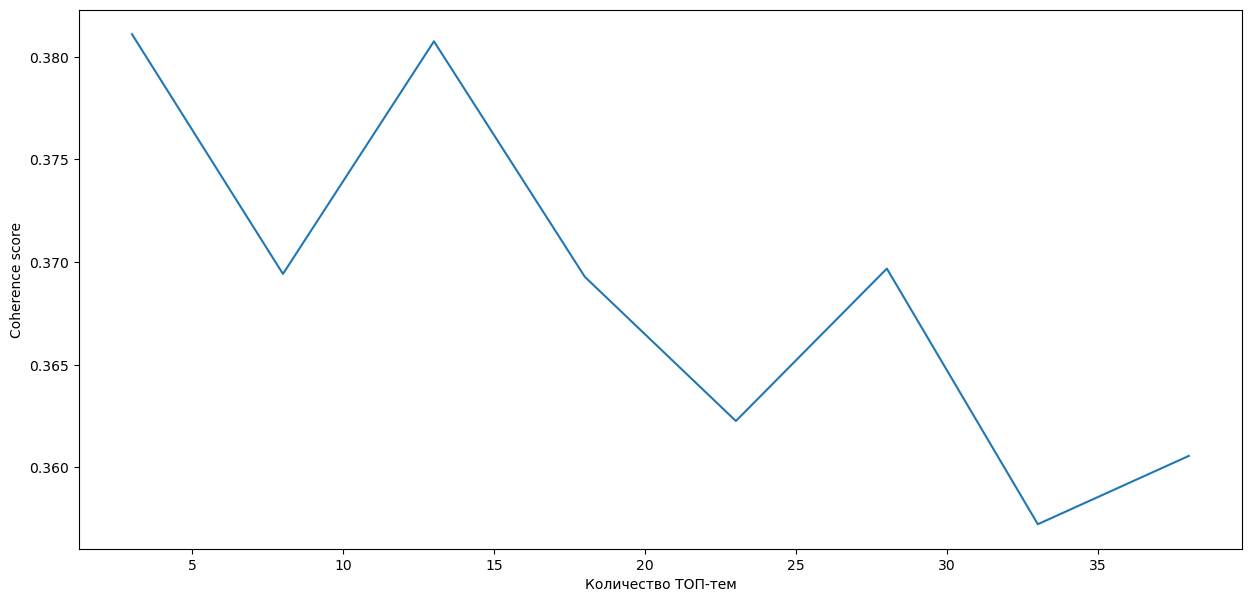

In [30]:
x = range(min_topic, max_topic, step)

plt.figure(figsize=(15, 7))

plt.plot(x, coherence_values)
plt.xlabel("Количество ТОП-тем")
plt.ylabel("Coherence score")

plt.show()

In [31]:
for n_topics, coherence in zip(x, coherence_values):
    print(f"ТОП-тем = {n_topics}, Coherence = {coherence:.3f}")

ТОП-тем = 3, Coherence = 0.381
ТОП-тем = 8, Coherence = 0.369
ТОП-тем = 13, Coherence = 0.381
ТОП-тем = 18, Coherence = 0.369
ТОП-тем = 23, Coherence = 0.362
ТОП-тем = 28, Coherence = 0.370
ТОП-тем = 33, Coherence = 0.357
ТОП-тем = 38, Coherence = 0.361


In [32]:
# Модель латентного размещения Дирихле
lda_model_ben = LatentDirichletAllocation(
    # кол-во тем
    n_components=38,
    max_iter=10,
    learning_method='online',
    random_state=RAND,
    n_jobs=-1,
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

LatentDirichletAllocation(learning_method='online', n_components=38, n_jobs=-1,
                          random_state=10)


In [33]:
get_coherence_mean(lda_model_ben, test_lst)

0.36056078914019146

In [34]:
panel = pyLDAvis.lda_model.prepare(lda_model_ben,
                                 test_vec_ben,
                                 vector_ben,
                                 mds='tsne')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -1.834725 -4.730178       1        1  13.209180
5     -2.551365 -7.007515       2        1  12.037182
9     -1.444291 -6.723120       3        1  11.750507
25    -2.044021 -5.000043       4        1   9.443444
23    -1.962486 -6.784922       5        1   8.758453
30    -2.565196 -6.944855       6        1   7.606217
13    -1.337010 -6.392310       7        1   6.642900
22    -3.232694 -6.561873       8        1   5.658199
28    -1.381845 -5.361091       9        1   4.371493
2     -3.367202 -5.529583      10        1   4.116576
36    -1.724478 -5.020483      11        1   2.914983
18    -2.217871 -4.699429      12        1   2.574628
33    -2.960046 -6.138109      13        1   2.324314
14    -1.688845 -5.514510      14        1   2.004887
16    -2.900292 -5.619102      15        1   1.237880
7     -2.526052 -5.292370      16        1   1.213046
19    -2.596046 -5.509872      17        1   0.817344
0     -2.775179 -6.017774      18        1   0.796425
8     -1.951153 -6.349074      19        1   0.795440
34    -1.706633 -5.933423      20        1   0.752652
32    -2.063026 -6.188837      21        1   0.368409
24    -2.202278 -6.015622      22        1   0.149838
29    -2.233095 -5.860429      23        1   0.028500
3     -2.248526 -5.872619      24        1   0.028500
35    -2.277016 -6.031048      25        1   0.028500
4     -2.243994 -5.894764      26        1   0.028500
31    -2.244863 -5.882132      27        1   0.028500
6     -2.201040 -5.833686      28        1   0.028500
17    -2.249086 -5.958152      29        1   0.028500
1     -2.224720 -5.939966      30        1   0.028500
27    -2.288529 -5.976332      31        1   0.028500
26    -2.233857 -6.055651      32        1   0.028500
11    -2.251602 -5.887146      33        1   0.028500
12    -2.244349 -5.874538      34        1   0.028500
15    -2.166612 -5.806506      35        1   0.028500
21    -2.243538 -5.903192      36        1   0.028500
20    -2.280416 -5.855329      37        1   0.028500
37    -2.250279 -5.875053      38        1   0.028500, topic_info=                            Term        Freq       Total Category  logprob   
110          параллельный работа  215.000000  215.000000  Default  30.0000  \
193     система электроснабжение  244.000000  244.000000  Default  29.0000   
25           выходной напряжение  133.000000  133.000000  Default  28.0000   
189        система регулирование  127.000000  127.000000  Default  27.0000   
225             угловой скорость   92.000000   92.000000  Default  26.0000   
..                           ...         ...         ...      ...      ...   
240           электрический сеть    0.011750   48.938482  Topic38  -5.4001   
203  статический преобразователь    0.011720   44.926088  Topic38  -5.4027   
225             угловой скорость    0.011795   92.320339  Topic38  -5.3963   
49                 изменение ток    0.011616   45.704087  Topic38  -5.4116   
113           первичный источник    0.011538   33.148878  Topic38  -5.4183   

     loglift  
110  30.0000  
193  29.0000  
25   28.0000  
189  27.0000  
225  26.0000  
..       ...  
240  -0.1714  
203  -0.0885  
225  -0.8023  
49   -0.1146  
113   0.1999  

[1882 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
0         1  0.440711   аварийный источник
0         4  0.305108   аварийный источник
0         7  0.033901   аварийный источник
0        11  0.067802   аварийный источник
1         1  0.238973  аварийный повышение
...     ...       ...                  ...
248       7  0.161759        это приводить
248       8  0.107839        это приводить
248      11  0.053920        это приводить
248      16  0.161759        это приводить
248      20  0.053920        это приводить

[2023 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab':

## Анализ тем

In [35]:
def predict_topic(data, vectorizer=vector_ben, model=lda_model_ben):
    
    transform_text = get_result(data)
    vec_text = vectorizer.transform([transform_text])
    topic_proba = model.transform(vec_text)[0]
    
    if np.all(topic_proba == topic_proba[0]) == True:
        return -9
    return np.argmax(topic_proba)

In [36]:
data['top_topic'] = data.text.transform(predict_topic)

In [37]:
data[:5]

,text,tema,top_topic
0,Процесс включения синхронного генератора на па...,Автоматизация включения генераторов на паралле...,2
1,"В тех случаях, когда не требуется гальваническ...",Автотрансформаторные ВУ,23
2,Выпрямители на диодах и тиристорах обладают из...,Активные выпрямители,28
3,\nВ системах электроснабжения ЛА имеют место к...,Анализ динамики процессов регулирования напряж...,5
4,Анализ процессов регулирования напряжения гене...,Анализ динамики процессов регулирования напряж...,5


In [38]:
# predict_topic()

In [39]:
predict_topic(np.nan)

-9

In [40]:
data[:3]

,text,tema,top_topic
0,Процесс включения синхронного генератора на па...,Автоматизация включения генераторов на паралле...,2
1,"В тех случаях, когда не требуется гальваническ...",Автотрансформаторные ВУ,23
2,Выпрямители на диодах и тиристорах обладают из...,Активные выпрямители,28


In [41]:
def show_topics(vectorizer, model, n_words=20):
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_words = []
    
    # проходимся по каждой теме
    for topic_weights in model.components_:
        # сортируем веса по убыванию (для каждого слова из словаря) и берем ТОП-N слов
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        # берем id ТОП слов из словаря (согласно весам)
        top_words.append(feature_names.take(top_keyword_locs))
        
    return top_words

In [42]:
topic_keywords = show_topics(vectorizer=vector_ben,
                             model=lda_model_ben,
                             n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = [
    'Word ' + str(i) for i in range(df_topic_keywords.shape[1])
]
df_topic_keywords.index = [
    'Topic ' + str(i + 1) for i in range(df_topic_keywords.shape[0])
]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 1,реактивный мощность,регулятор частота,ток генератор,схема включение,линейный напряжение,напряжение генератор,генератор регулятор,векторный диаграмма,схема рис,ток протекать,активный мощность,мощность генератор,параллельный работа генератор,параллельный работа,напряжение выход
Topic 2,выпрямить напряжение,ток нагрузка,обмотка трансформатор,падение напряжение,значение ток,средний значение,вторичный обмотка,активный сопротивление,иметь вид,равный нуль,нагрузка напряжение,напряжение выход,вторичный обмотка трансформатор,напряжение привести,изменение ток
Topic 3,параллельный работа,генератор параллельный работа,генератор параллельный,включение генератор,активный мощность,работа генератор,параллельный работа генератор,мощность генератор,реактивный мощность,напряжение сеть,возбуждение генератор,напряжение частота,синхронный генератор,частота вращение,постоянный ток
Topic 4,настоящий время,иметь место,напряжение переменный ток,качество электрический,параллельный работа генератор,система регулирование напряжение,постоянный время,напряжение частота,распределительный устройство,постоянный переменный,широкий применение,общий случай,линейный напряжение,напряжение выход,ток генератор
Topic 5,система регулирование,обратный связь,ток обмотка,частота вращение,напряжение генератор,это приводить,регулирование напряжение,настоящий время,привести рис,принципиальный схема,источник ток,система регулирование напряжение,напряжение иметь,регулятор напряжение,статический преобразователь
Topic 6,система регулирование,регулирование напряжение,система регулирование напряжение,регулятор напряжение,напряжение генератор,обмотка возбуждение,частота вращение,возбуждение генератор,ток возбуждение,обратный связь,коэффициент усиление,ток нагрузка,режим работа,постоянный время,измерительный орган
Topic 7,защита управление,короткий замыкание,повышение напряжение,постоянный частота,переменный ток,система электроснабжение,значение напряжение,напряжение генератор,постоянный ток,действовать значение,параллельный работа,напряжение постоянный,возбуждение генератор,привод постоянный,напряжение переменный
Topic 8,напряжение генератор,напряжение сеть,режим работа,это приводить,система электроснабжение,аппарат защита,генератор ток,защита управление,протекание ток,бортовый сеть,система распределение,включение генератор,распределение электроэнергия,ток генератор,представить рис
Topic 9,измерительный орган,регулятор напряжение,выходной напряжение,значение напряжение,линейный напряжение,работать режим,напряжение выход,действовать значение,система электроснабжение,оставаться постоянный,входной напряжение,принципиальный схема,напряжение генератор,показать рис,рис схема
Topic 10,параллельный работа,ток напряжение,структурный схема,аккумуляторный батарея,выходной напряжение,обратный связь,значение напряжение,напряжение нагрузка,действовать значение,система управление,сигнал управление,представить рис,переменный ток,привести рис,постоянный ток


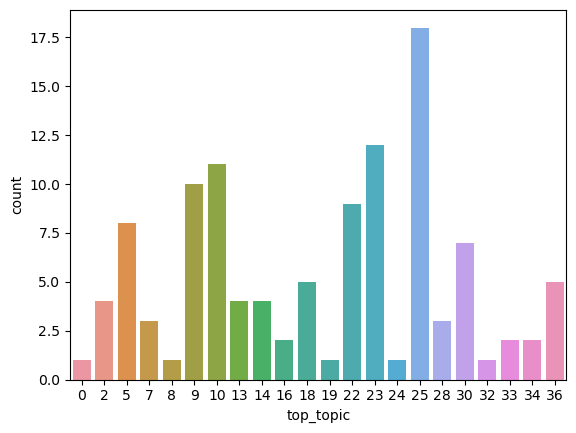

In [43]:
sns.countplot(x='top_topic', data=data[data.top_topic != -9]);